## A. Data reading

*Notes:* 
- In this notebook, I briefly mention the steps I followed for completing the project. A more detailed analysis exists on the respective report pdf.
- I keep here all of the code I used during my experiments, even though it may not be used for the final model.
- For this ipynb, I skiped the data analysis part, as it already exists on the ipynb file for the BERT model.

In [1]:
import pandas as pd 
import numpy as np
import re 
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,precision_recall_fscore_support 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import STOPWORDS
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import torch
import warnings
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import random
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import shutil

# supress warnings
warnings.filterwarnings('ignore')

2025-05-25 16:47:01.043690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748191621.224396      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748191621.274106      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Random seed for reprodicibility and GPU.

In [2]:
SEED = 43 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

#use gpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Reading the datasets

In [3]:
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/train_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/test_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/val_dataset.csv")

print(f"{train_df.head(20)}\n")
train_df.describe()

        ID                                               Text  Label
0   189385      @whoisralphie dude  I'm so bummed ur leaving!      0
1    58036  oh my god, a severed foot was foun in a wheely...      0
2   190139  I end up &quot;dog dialing&quot; sumtimes. Wha...      1
3    99313                         @_rachelx meeeee toooooo!       0
4   157825  I was hoping I could stay home and work today,...      0
5   130560  says plurk karma finally reached the 50s. stil...      0
6   121871  Good to hear it @Arth This is a bit more, but ...      1
7    86813  @davorg in that case im gonna start tweeting a...      1
8   197517          @belunyc its alright love, how are you?        1
9     6937  @brightondoll haha that has to be the best ana...      1
10   92703  @AlpacaFarmgirl Biscuit is our cat. We've had ...      0
11  197003  @1capplegate I'm so sad about Sam Who  it was ...      0
12   23724  trying to stay healthy. 2 of 4 of this Devine ...      0
13   23205  My bro stole my big ba

,ID,Label
count,148388.000000,148388.000000
mean,106024.578699,0.500013
std,61150.300085,0.500002
min,0.000000,0.000000
25%,53237.500000,0.000000
50%,105998.000000,1.000000
75%,158927.250000,1.000000
max,211981.000000,1.000000


## B. Data preprocessing


preprocess() func returns the proccesed text. <br>
We use the same preprocesssing as for the Bert model.

In [4]:
def preprocess(text):
    # urls
    text = re.sub(r"http\S+|www\S+|https\S+", "[URL]", text, flags=re.MULTILINE)
    # html
    text = re.sub(r"&\w+;", "", text)
    # mentions 
    text = re.sub(r"@\w+", "@user", text)
    # whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

remove_stopwords() func removes the stopwords for the given text. <br>
We will only use it if removing them boosts our model's performance.

In [5]:
customStop = {'im', 'u', 'them', 'this', 'that', 'these', 'those', 'and'}

def remove_stopwords(text):
    stopWords = set(stopwords.words('english'))
    stopWords.update(customStop)
    wordToks = word_tokenize(text.lower())  
    newText = [word for word in wordToks if word not in stopWords and word.isalnum()]
    return ' '.join(newText)

lemm_text() and stem_text() are used for text lemmatization and stemming. <br>
Again, we will only use these techniques if they boost our model's performance.

In [6]:
nltk.data.path.append("/kaggle/input/wordnet/")
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    words = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word) for word in words])

def stem_text(text):
    words = nltk.word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])

Apply preprocessing

In [7]:
#nltk.download("punkt")
#nltk.download('punkt_tab')

# preprocess
train_df["Text"] = train_df["Text"].apply(preprocess)
val_df["Text"] = val_df["Text"].apply(preprocess)
test_df["Text"] = test_df["Text"].apply(preprocess)

# drop any rows that preprocess func returned as None
# train_df = train_df.dropna(subset=["Text"]).reset_index(drop=True)
# val_df = val_df.dropna(subset=["Text"]).reset_index(drop=True)

# stopwords removal
# train_df["Text"] = train_df["Text"].apply(remove_stopwords)
# val_df["Text"] = val_df["Text"].apply(remove_stopwords)
# test_df["Text"] = test_df["Text"].apply(remove_stopwords)


# stemming
# train_df["Text"] = train_df["Text"].apply(stem_text)
# val_df["Text"] = val_df["Text"].apply(stem_text)
# test_df["Text"] = test_df["Text"].apply(stem_text)

# lemmatize
# train_df["Text"] = train_df["Text"].apply(lemmatize_text)
# val_df["Text"] = val_df["Text"].apply(lemmatize_text)
# test_df["Text"] = test_df["Text"].apply(lemmatize_text)

print(f"{train_df.head(20)}\n")
train_df.describe()

        ID                                               Text  Label
0   189385               @user dude I'm so bummed ur leaving!      0
1    58036  oh my god, a severed foot was foun in a wheely...      0
2   190139  I end up dog dialing sumtimes. What's dog dial...      1
3    99313                              @user meeeee toooooo!      0
4   157825  I was hoping I could stay home and work today,...      0
5   130560  says plurk karma finally reached the 50s. stil...      0
6   121871  Good to hear it @user This is a bit more, but ...      1
7    86813  @user in that case im gonna start tweeting abo...      1
8   197517               @user its alright love, how are you?      1
9     6937  @user haha that has to be the best analogy eve...      1
10   92703  @user Biscuit is our cat. We've had him for 4 ...      0
11  197003  @user I'm so sad about Sam Who it was my favor...      0
12   23724  trying to stay healthy. 2 of 4 of this Devine ...      0
13   23205  My bro stole my big ba

,ID,Label
count,148388.000000,148388.000000
mean,106024.578699,0.500013
std,61150.300085,0.500002
min,0.000000,0.000000
25%,53237.500000,0.000000
50%,105998.000000,1.000000
75%,158927.250000,1.000000
max,211981.000000,1.000000


## C. Vectorization

We will use DistilBertTokenizer for tokenization with the the pretrained model 'distilbert-base-uncased'.

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

We define a custom TwitterDataset class for handling data tokenization and converting to tensors for PyTorch .

In [9]:
class TwitterDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer   # DistilBertTokenizer
        self.max_length = max_length # max tokens length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # tokenizing
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length, # fixed max length 
            padding='max_length',  # pad to max length
            truncation=True,    # truncate longer
            return_tensors='pt'
        )
        
        # to tensors 
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # for train, val datasets
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': label
            }
        else: # test dataset
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

Converting datasets

In [10]:
train_dataset = TwitterDataset(
    texts=train_df['Text'].values,
    labels=train_df['Label'].values,  
    tokenizer=tokenizer
)

val_dataset = TwitterDataset(
    texts=val_df['Text'].values,
    labels=val_df['Label'].values,  
    tokenizer=tokenizer
)

test_dataset = TwitterDataset(
    texts=test_df['Text'].values,
    labels=None,
    tokenizer=tokenizer
)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle for train only
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Setting up the model, initializing optimizer and scheduler.

In [11]:
num_labels = len(train_df['Label'].unique())  
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model.to(device) # gpu 

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01) # TODO: add weight_decay

# training epochs
epochs = 2

# total steps needed
total_steps = len(train_loader) * epochs

# learning rate scheduler with linear warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,     # TODO: also try 100 
    num_training_steps=total_steps
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## D. Model Training & Evaluation.

Defining the training process for an epoch

In [12]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # progress
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        # to gpu
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # save loss
        loss = outputs.loss
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        scheduler.step()
        
        # get predictions
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        # update progress
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    # metrics for the epoch (train)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return total_loss / len(data_loader), accuracy, precision, recall, f1

**evaluate()** func will be used to evaluate our model based on precision, recall, F1 and accuracy.
We perform evaluation after each completed epoch, to keep track of model's performance during training.

In [13]:
def evaluate(model, data_loader, device, roc_flag, conf_flag):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = [] # to store probabilities for ROC
    
    progress_bar = tqdm(data_loader, desc="Evaluating")
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            # loss
            loss = outputs.loss
            total_loss += loss.item()
            
            # get predictions
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
            
            # update progress
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    ########################################
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    ########################################
    
    # get metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')


    ########################################
    if roc_flag and conf_flag:
        
        # confusion matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(all_labels, all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=range(len(np.unique(all_labels))), 
                    yticklabels=range(len(np.unique(all_labels))))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        #plt.savefig('Confusion-mtrx.png')
        plt.close()

        # roc curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
            
    
    
    return total_loss / len(data_loader), accuracy, precision, recall, f1

Training phase and evaluation for our final model


Epoch 1/2


Evaluating: 100%|██████████| 332/332 [01:34<00:00,  3.50it/s, loss=0.3981]


Train Loss: 0.3908, Accuracy: 0.8232, Precision: 0.8232, Recall: 0.8232, F1: 0.8232
Val Loss: 0.3540, Accuracy: 0.8433, Precision: 0.8437, Recall: 0.8433, F1: 0.8432
Epoch 2/2


Evaluating: 100%|██████████| 332/332 [01:34<00:00,  3.50it/s, loss=0.3335]


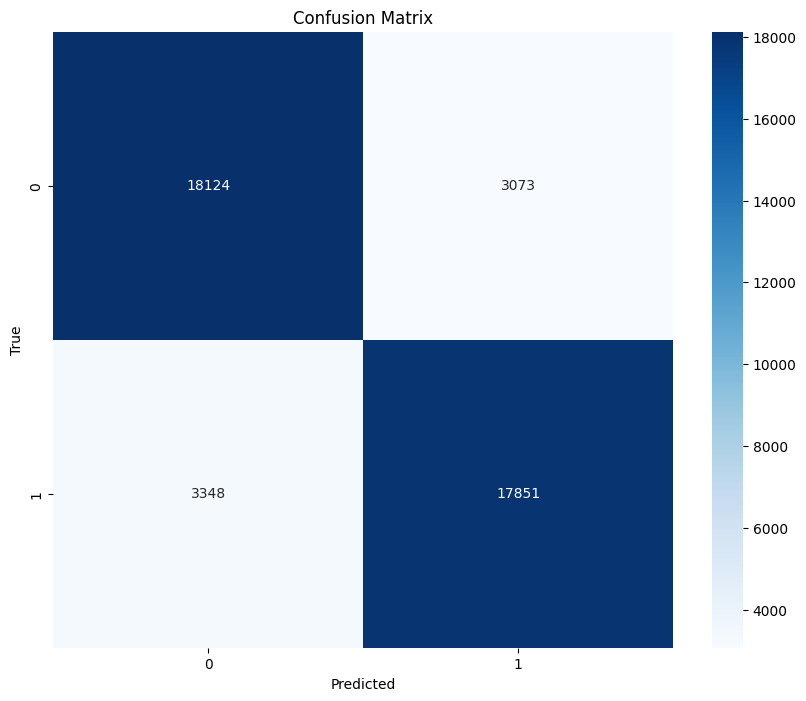

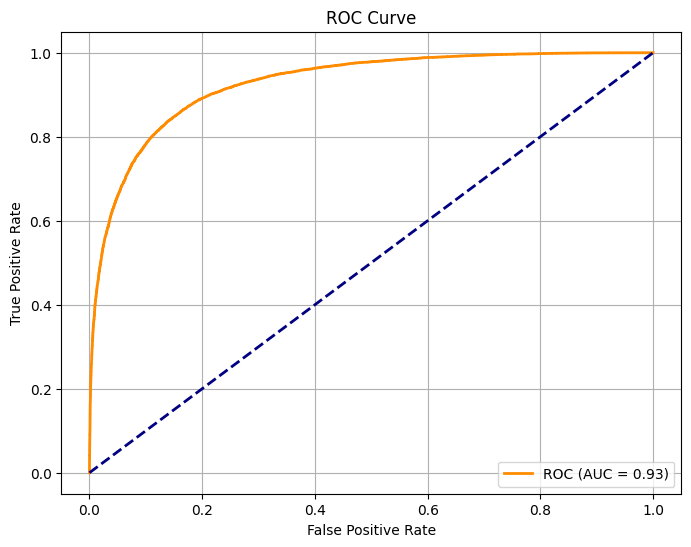

Train Loss: 0.2887, Accuracy: 0.8790, Precision: 0.8790, Recall: 0.8790, F1: 0.8790
Val Loss: 0.3562, Accuracy: 0.8485, Precision: 0.8486, Recall: 0.8485, F1: 0.8485


In [14]:
# to save metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
val_precisions = []
val_recalls = []
val_f1s = []

roc_flag = False
conf_flag = False

# main training loop 
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # train
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    
    # print curves on last epoch
    if epoch == epochs-1:
        roc_flag = True
        conf_flag = True

    # evaluate
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(model, val_loader, device, roc_flag, conf_flag)
    
    # store every metric 
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

Learning curves to evaluate how our model performs during the training phase.

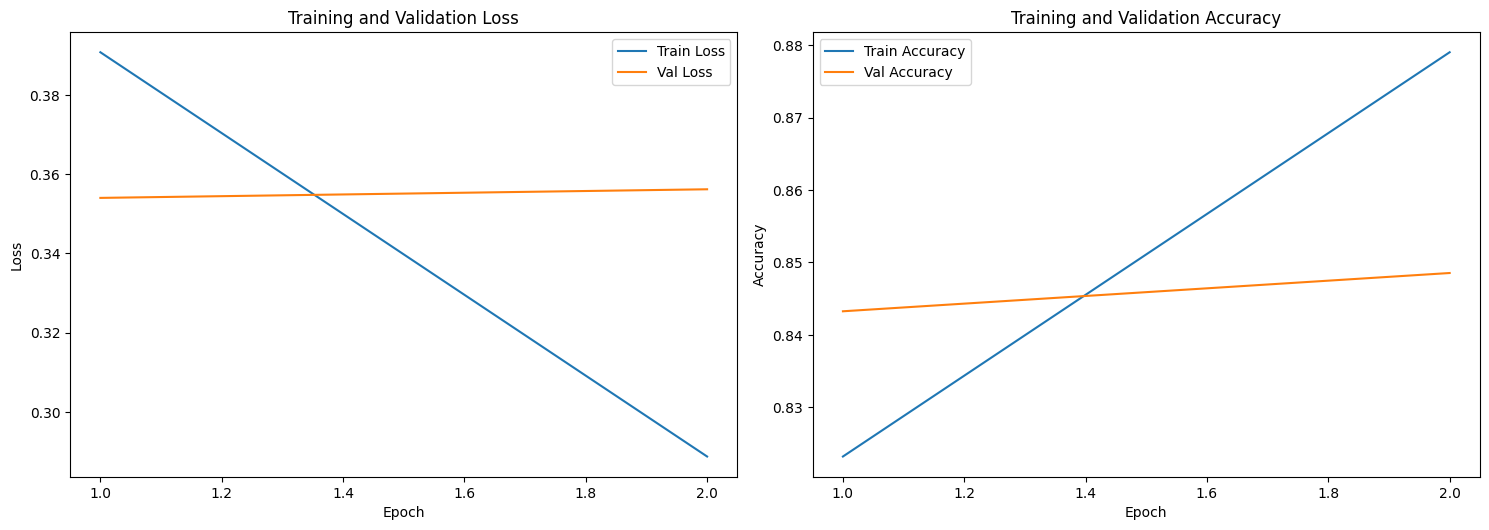

In [15]:
# plots for training/validation
plt.figure(figsize=(15, 10))

# loss
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
#plt.savefig('bert_training_metrics.png')
plt.show()

Final predictions on test dataset and creation of the submission.csv.

In [16]:
model.eval()
test_predictions = []

# get predictions
with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Generating predictions")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_predictions.extend(preds)

# save the final submission file
submission = pd.DataFrame({
    'ID': test_df["ID"],
    'Label': [int(pred) for pred in test_predictions]
})

submission.to_csv('submission.csv', index=False)

Generating predictions: 100%|██████████| 166/166 [00:46<00:00,  3.55it/s]
